# Preparation of milestone three

Today we will start preparing the third milestone. The third milestone is to train an object detector to recognize cells. To successfully complete the milestone, you will have to complete the following sub-tasks:
- Initialize a pytorch object detector. I'd suggest to choose a RetinaNet or FCOS detection model. More Information can be found [here](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection). Since we do not have endless compute power available, we will use a pre-trained backbone and only train the detection and classification heads of our object detector. So you will have to finde a way to **freeze** the backbone of your detector.
- You will have to write a [training and validation/test](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) loop to train your detector. Make sure you measure the convergence of the training by monitoring a detection metric like the [mAP](https://torchmetrics.readthedocs.io/en/stable/detection/mean_average_precision.html). Also, you will have to find a way to select the best model during training based on some metric. The detection models of torchvision already return a loss when they are in evaluation mode, so you don't need to configure your own one.
- Train your model for a few epochs. If you do not have a gpu available, I suggest using colab, as training the model on the cpu is extremely slow. You will also need to pass your dataset to a dataloader to take advantage of multithreading and automatic batching.
- At the end, you will have to save the **state_dict** of your trained object detector, to be able to reuse it later.

Please use a jupyter notebook for coding your training/testing pipeline. In the end, you will have to submit that jupiter notebook at moodle. Please do not try to upload any model weights.

# 1. Create a Custom Dataset Class for training your object detection model

In the last milestone, you learned about custom data sets in pytorch. In this milestone, we are going to train an object detection model, for which we also need a custom dataset. Last time, the dataset returned only one cell each time the getitem method was called. This time, we need to return a larger portion of the image to feed the object detector. Since there may be more than one cell in the image, you will also need to return the labels and bounding box information for each cell in the respective crop. Think about how to deal with cells that are at the edges of the crop and therefore not completely visible. Also consider what to do if there is no annotation on the image.

Your dataset must have the following characteristics:

1. Since you are going to randomly sample the crops from the images, you need a parameter that defines how many crops will be sampled in an epoch (num_samples).
2. You need to define the size of the patches that will be sampled from the images during training (crop_size).
3. Since we do not have many images available, we will need image augmentation. Geometric augmentations are a bit tricky for object detection, because you always have to transform the bounding boxes as well. The [albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/) module solves this quite nicely, so I suggest using it for the augmentations in this task.
4. Have a look at pytorch and torchmetrics to see in which format the metrics as well as the models expect the images and tragets.
5. Although we do not actively detect a background class, the label "0" is always reserved for the background class. Therefore, your dataset must return the label "1" for each cell.

In [52]:
import torch

device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(device)

mps


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import os
import numpy as np
from tqdm import tqdm  # for progress bar
import time
import random


In [54]:
# Load and inspect the annotation CSV file
annotation_path = 'annotation_frame.csv'
annotations = pd.read_csv(annotation_path)
print(annotations.head())

image_path = 'data/AgNORs/images/'  

          filename  max_x  max_y  min_x  min_y  label
0  AgNOR_0495.tiff     26     41      4     15      1
1  AgNOR_0495.tiff     71     23     42      0      2
2  AgNOR_0495.tiff    133     61    104     37      1
3  AgNOR_0495.tiff    143    117    121     88      2
4  AgNOR_0495.tiff    224     37    199     12      1


In [55]:

# Verify image paths
img_dir = "data/AgNORs"  # Update this path as necessary
image_files = os.listdir(img_dir)

In [56]:
invalid_images = []

for img_file in image_files:
    img_path = os.path.join(img_dir, img_file)
    try:
        img = Image.open(img_path)
        img.verify()  # Verify if the image can be opened
    except (UnidentifiedImageError, IOError):
        invalid_images.append(img_file)

print(f"Invalid images: {invalid_images}")

# Filter out invalid images from the annotations
valid_annotations = annotations[~annotations['filename'].isin(invalid_images)]

# Verify and correct labels
unique_labels = valid_annotations['label'].unique()
print("Unique labels in annotations before correction:", unique_labels)

# Adjust labels if necessary
valid_annotations['label'] = valid_annotations['label'].apply(lambda x: 1 if x > 0 else 0)

# Verify labels after correction
unique_labels = valid_annotations['label'].unique()
print("Unique labels in annotations after correction:", unique_labels)

# Filter out invalid bounding boxes
valid_annotations = valid_annotations[(valid_annotations['max_x'] > valid_annotations['min_x']) &
                                      (valid_annotations['max_y'] > valid_annotations['min_y'])]


Invalid images: []
Unique labels in annotations before correction: [ 1  2  3  0  4  5  7  6  9  8 10 11]
Unique labels in annotations after correction: [1 0]


In [57]:
class CellsDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform
        self.imgs = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        
        # Apply transformation if provided
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = F.to_tensor(img)
        
        # Get bounding boxes and labels
        img_annotations = self.annotations[self.annotations['filename'] == self.imgs[idx]]
        boxes = img_annotations[['min_x', 'min_y', 'max_x', 'max_y']].values
        labels = img_annotations['label'].values
        
        # Ensure all bounding boxes are valid
        valid_boxes = []
        valid_labels = []
        for box, label in zip(boxes, labels):
            if box[2] > box[0] and box[3] > box[1]:  # Check if box is valid
                valid_boxes.append(box)
                valid_labels.append(label)
        
        if valid_boxes:
            boxes = np.array(valid_boxes, dtype=np.float32)
            labels = np.array(valid_labels, dtype=np.int64)
        else:
            boxes = np.zeros((0, 4), dtype=np.float32)
            labels = np.zeros((0,), dtype=np.int64)
        
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        return img, target


In [58]:
# Create dataset and data loader with valid annotations
dataset = CellsDataset(valid_annotations, img_dir)

# Split the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [59]:
# Define the transformations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=20, shift_limit=0.2, p=0.5, border_mode=0),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# 2. Initializing the model

Initialize a pre-trained object detector from torchvision. Since you need to detect cells, you need two classes (a background class and a "cell" class). Some detection models like FasterRCNN or Retinanet use anchor boxes. If you choose to work with one of these models, you will need to select anchorboxes with a size that matches the size of the detection targets.

In [60]:
# Initialize the model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier head to match the number of classes
num_classes = 2  # Background and cell
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Freeze the backbone layers
for param in model.backbone.parameters():
    param.requires_grad = False




/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 3. Setting up an optimzer, a detection metric and the train and validation dataloaders

To train the object detector, it is necessary to select an appropriate optimizer. Additionally, the torchmetrics class needs to be instantiated before it can be used for evaluation or tracking metrics during training.
Additionally, initialize a training and validation dataloader your dataset. For more information on how to set up your dataloaders have a look [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)


In [61]:
# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# 4. Train and validation loop

Please write two functions, one for training and one for evaluating your object detector. The functionality should be very similar to what you had to do for the last milestone. Use these functions to train the detector for a few epochs. During training, track both the training losses and the validation metrics to monitor the performance of the model. Save the best detector as observed by the validation metric.

In [62]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    running_loss = 0.0
    for images, targets in tqdm(data_loader, desc=f"Epoch {epoch+1} Training", leave=False):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    return running_loss / len(data_loader)




In [63]:
def evaluate(model, data_loader, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Validation", leave=False):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Calculate losses during evaluation
            if model.training:
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                running_loss += losses.item()
            else:
                outputs = model(images)
                # Here you might want to calculate validation metrics using `outputs` and `targets`
                # For now, just calculate a dummy loss (replace this with actual validation metric calculation)
                dummy_loss = torch.tensor(0.0, device=device)
                running_loss += dummy_loss.item()

    return running_loss / len(data_loader)


In [64]:
# # Verify and correct labels
# unique_labels = annotations['label'].unique()
# print("Unique labels in annotations before correction:", unique_labels)

# # Adjust labels if necessary
# annotations['label'] = annotations['label'].apply(lambda x: 1 if x > 0 else 0)

# # Verify labels after correction
# unique_labels = annotations['label'].unique()
# print("Unique labels in annotations after correction:", unique_labels)


In [65]:
num_epochs = 2

# Move model to device
model.to(device)

# Training loop
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    val_loss = evaluate(model, val_loader, device)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

# Save the model
torch.save(model.state_dict(), "cell_detector.pth")


Epoch 1, Train Loss: 5.091307759284973, Validation Loss: 0.0


Epoch 2, Train Loss: 2.1644152204195657, Validation Loss: 0.0


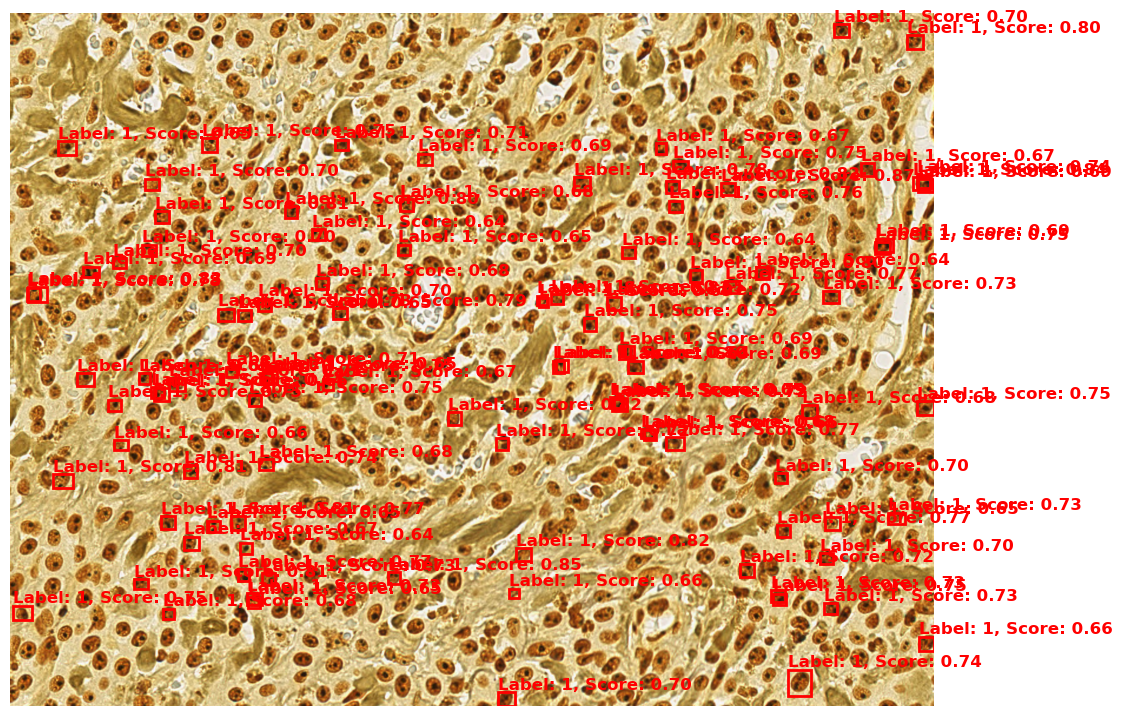

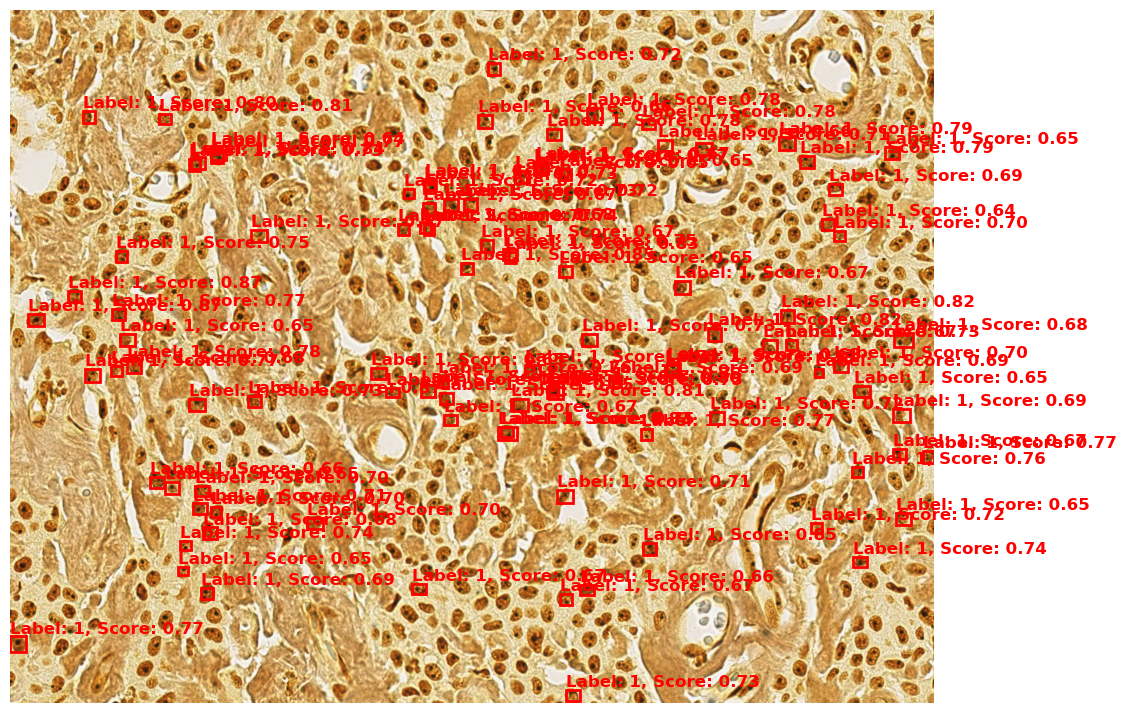

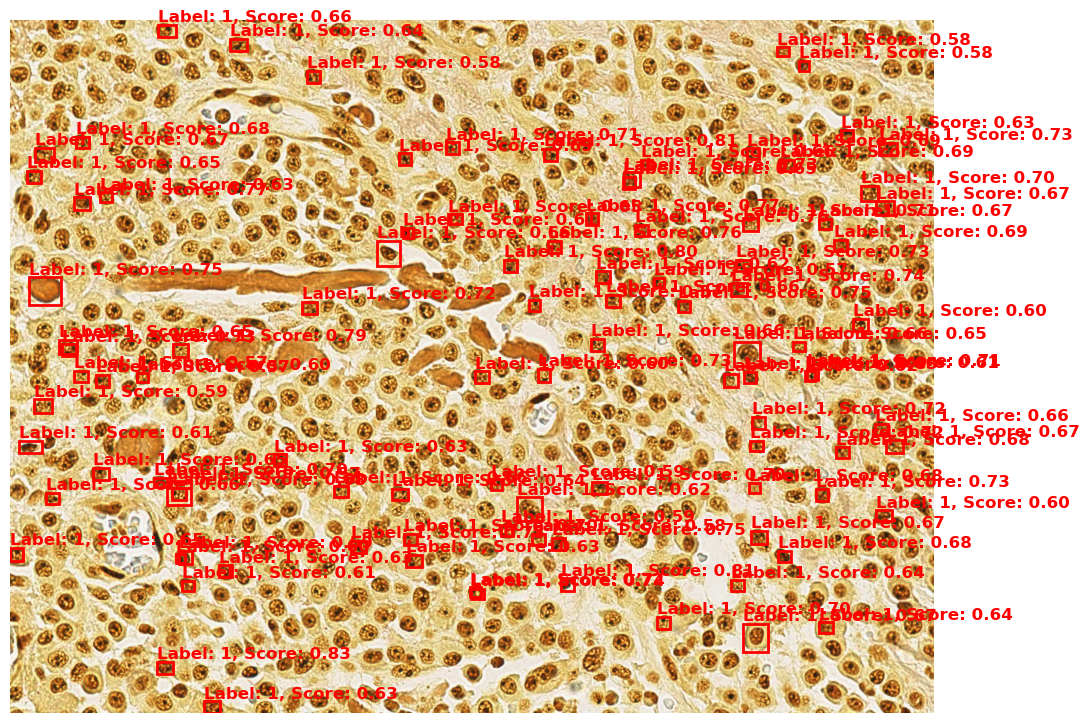

In [66]:
# Visualization function
def visualize_predictions(model, dataset, device, idx=0, threshold=0.5):
    model.eval()
    img, _ = dataset[idx]
    with torch.no_grad():
        prediction = model([img.to(device)])
    
    img = img.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img)
    
    for box, score, label in zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels']):
        if score >= threshold:
            box = box.cpu().numpy()
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(box[0], box[1] - 5, f"Label: {label.item()}, Score: {score.item():.2f}", color='red', fontsize=12, weight='bold')
    
    plt.axis('off')
    plt.show()

# Example usage to visualize predictions on the first image in the validation dataset
visualize_predictions(model, val_dataset, device, idx=0, threshold=0.5)

# Visualize predictions on a few more images
visualize_predictions(model, val_dataset, device, idx=1, threshold=0.5)
visualize_predictions(model, val_dataset, device, idx=2, threshold=0.5)
